# Script to make a fit of the Ha-Xray relation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import os
import time
from matplotlib import colormaps, gridspec
from time import perf_counter
from tqdm import tqdm



#ASTROPY
from astropy.visualization import astropy_mpl_style
from astropy.io import fits
from astropy import units as u
from astropy.units import J, erg, pc, m, kg, s, d, km, yr

#MASKS
from photutils.aperture import CircularAperture, EllipticalAperture, RectangularAperture, ApertureMask, BoundingBox
from astropy.coordinates import Angle

#SCIPY
from scipy.optimize import curve_fit

plt.style.use(astropy_mpl_style)



# Function that converts from pixels to parsecs using the pixel scale, with the definition of the tangent,
# being the long side of the right triangle the distance to M33 (dM33) and de pixscl the angle.
def pix2pc(npix):
    a = 0.32 #pixel scale [a]=arcsec
    dM33 = 812000 * u.pc
    return npix*dM33*np.tan(np.deg2rad(a/3600.))
    
def F2L(flux):
    dM33 = 812000 * u.pc
    R = dM33.to(u.m)
    return flux*4*np.pi*R**2

def L2F(lum):
    dM33 = 812000 * u.pc
    R = dM33.to(u.m)
    return lum/(4*np.pi*R**2)

units = { 'N':' ', 'x':'[pix]', 'y':'[pix]', 'dist':'[pix]', 'Haflux':'[erg/cm$^2$s]', 'SII6717flux':'[erg/cm$^2$s]', 
         'SII6731flux':'[erg/cm$^2$s]', 'sigma':'[km/s]','heliocentric-velocity':'[km/s]', 'SII/Ha':' ',
         'SIIflux':'[erg/cm$^2$s]', 'R':'[pix]' , 'distpc':'[pc]', 'Lx':'[J/s]'}

/var/folders/44/s9hhm3bx4jx_tvwn2m_84gk00000gn/T/ipykernel_2183/3769693243.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


# Functions

## Decorations

In [4]:
def get_time(func):
    def wrapper(*args, **kwargs):

        # Note that timing your code once isn't the most reliable option
        # for timing your code. Look into the timeit module for more accurate
        # timing.
        start_time: float = perf_counter()
        result: Any = func(*args, **kwargs)
        end_time: float = perf_counter()

        print(f'"{func.__name__}()" took {end_time - start_time:.3f} seconds to execute')
        return result

    return wrapper

## Tables

In [5]:
"""Error"""
def Error(tabFtot: pd.DataFrame) -> pd.DataFrame:
    '''
    # Function that does the error propagation a table, recieves:
    # (tabFd)   The table to propagate
    '''
    #Adds to Ftot
    #Adding the SII/Ha term
    tabFtot['SIIflux'] = tabFtot['SII6717flux']+tabFtot['SII6731flux']
    tabFtot['SII/Ha'] = (tabFtot['SII6717flux']+tabFtot['SII6731flux'])/tabFtot['Haflux']
    # Errors and S/N # S/N only calc. for the direct measurements, not indirect calculations.
    tabFtot['SIIflux-err'] = np.sqrt(tabFtot['SII6717flux-err']**2+tabFtot['SII6731flux-err']**2)
    tabFtot['SII/Ha-err']  = np.sqrt(((tabFtot['SIIflux']*tabFtot['Haflux-err'])/tabFtot['Haflux']**2)**2+ 
                                  ((tabFtot['SII6717flux']*tabFtot['SII6731flux-err'])/tabFtot['Haflux'])**2+
                                  ((tabFtot['SII6731flux']*tabFtot['SII6717flux-err'])/tabFtot['Haflux'])**2)
    tabFtot['S/N-Haflux'] = tabFtot['SII/Ha']/tabFtot['SII/Ha-err']
    tabFtot['S/N-SIIflux'] = tabFtot['SII/Ha']/tabFtot['SII/Ha-err']

    return tabFtot

In [6]:
def list_isin(elem, L: list) -> list:
    return [elem in s for s in L]

# Function that reads a fits file with a cutout of a SNR and makes a table
# Tablas de posición distancia y flujo.
# Updated to take multi-extended HDUL
def tableFd(fname: str):
    
    #Read fits and extract data
    with fits.open(fname) as hdul:
        h0 = hdul[0].header
        dn = [hdul[i].data for i in range(len(hdul))] #We put all the data into an array
    ab     = (h0['A'],h0['B'])
    Type   = [ h0['TYPE'+str(i)] for i in range(len(hdul))] #extraction of the types in their order
    # For the radious we approximate to the major axis
    cnt = (ab[0],ab[0])

    # Generate a list for each parámeter
    x = []
    y = []
    F = [ [] for i in range(len(hdul))]
    for a in range(len(dn[0])):
      for b in range(len(dn[0][0])):
          x.append(a)
          y.append(b)
          for i in range(len(hdul)):
              F[i].append(dn[i][a,b])
    ## signma for each pixel if availeable, if not the same for all. ##
    # distance
    dist = [ np.sqrt((x[i]-cnt[0])**2+(y[i]-cnt[1])**2) for i in range(len(x))]
    # we get the name from the file directory and produce a list
    name = re.search(r'(L\d\d-\w+)', fname)
    N = [ name.group() for i in range(len(x))]

    coord = {'N': N, 'x':x,'y':y, 'dist':dist}
    data  = { t:f for (t,f) in zip(Type,F) }
    # We sume the two with the update method
    coord.update(data)
    
    return pd.DataFrame(data=coord)

#Funcion que genera un DF con una sola fila de nombre, radio,centro, valores de flujo integrados y sigma. 
#Recibe un fits file de SNR con parameters de recorte en el header
#Function that generates a DataFrame with a single row
# Updated to take multi-extended HDUL
def tableFtot(fname: str):
    '''
    Recieves the name of the HDUL that we want to turn into a table
    '''
    #Read fits and extract data
    with fits.open(fname) as hdul:
        h0 = hdul[0].header  # Header for all the images
        dn = [hdul[i].data for i in range(len(hdul))] # Data of each image 
    ab  = (h0['A'],h0['B'])
    cnt = (ab[0],ab[0])
    r = np.nanmax(ab)
    Type  = [ h0['TYPE'+str(i)] for i in range(len(dn))] #Extracting each type according to the data order
    name  = re.search(r'L\d\d-\w+', fname).group()
    field = h0['LABEL']
    morf  = h0['MORF'] 
    Ftot = []
    
    # Integration of the data taking into account the error.
    error = list_isin('-err',Type)
    for i in range(len(dn)):
        if error[i]: 
            errsum = np.sqrt(np.nansum([dn[i][j][k]**2 for (j,k) in zip(range(len(dn[0])),range(len(dn[0][0])))]))
            Ftot.append(errsum)
        elif (Type[i]=='sigma') or (Type[i]=='heliocentric-velocity'):Ftot.append(np.nanmean(dn[i]))
        else: Ftot.append(np.nansum(dn[i]))
        
    # Dictionaries that make up the DF
    param = { 'N':name, 'Field':field, 'Morf':morf, 'R':r, 'R(pc)': pix2pc(r), 'R-err(pc)':pix2pc(1), 'Cent':cnt}
    total  = { t:f for (t,f) in zip(Type,Ftot) }
    param.update(total)
    
    return pd.DataFrame(param).drop(1,axis=0)

def multyFtot(dir: str) -> pd.DataFrame:
    '''
    Makes just the total table for all the given folders of SNRs
    '''
    # Getting all the file paths
    fpath = []
    folders = os.listdir(dir);  # Get the folders
    if '.DS_Store' in folders: folders.remove('.DS_Store')
    
    for f in folders:
      folpath = os.path.join(dir, f)
      files = os.listdir(folpath); # Files in the folder
      if '.DS_Store' in files: files.remove('.DS_Store')
      for a in files:
        fpath.append(os.path.join(folpath, a)) # Adding the filepath to the list

    # Generate the total table
    tabFtot1 = pd.concat([ tableFtot(fn) for fn in tqdm(fpath) ])# Add all the rows together
    tabFtot = tabFtot1[tabFtot1!=np.nan]                   # We take only the values with no nan
    tabFtot = Error(tabFtot)             # Adding indirect terms and errors
    tabFtot = tabFtot.sort_values('N').reset_index(drop=True)      # Reindexation

    return tabFtot
    
    



# (dir) The absolute path to the folder where to get the fits
# Returns the to tables as a list
@get_time
def tables2(dir: str, multi: bool=False) -> list:
    '''
    (dir:   str ) The absolute path to the folder where to get the fits
    (multi: bool) If True looks into different folders
    '''
    if multi == True:
        fpath = []
        folders = os.listdir(dir); 
        if '.DS_Store' in folders: folders.remove('.DS_Store')
        
        for f in folders:
          folpath = os.path.join(dir, f)
          files = os.listdir(folpath); 
          if '.DS_Store' in files: files.remove('.DS_Store')
          for a in files:
            fpath.append(os.path.join(folpath, a))
    else:
        fnames = os.listdir(dir)
        if '.DS_Store' in fnames: fnames.remove('.DS_Store')
        fnames.sort()
        fpath = [os.path.join(dir,fn) for fn in fnames]
    

    # Generate the 1st table
    LFd = [ tableFd(fn) for fn in fpath ]
    tabFd1 = pd.concat(LFd) 
    # Generate the 2nd table
    tabFtot1 = pd.concat([ tableFtot(fn) for fn in fpath ])

    # We take only the values with no nan
    tabFd   = tabFd1[tabFd1!=np.nan]
    tabFtot = tabFtot1[tabFtot1!=np.nan]
    # Reindexation
    tabFd.reset_index(drop=True, inplace=True)
    tabFtot.reset_index(drop=True, inplace=True)
    
    #Adds to Fd
    #Adding the SII/Ha term
    tabFd['SIIflux'] = tabFd['SII6717flux']+tabFd['SII6731flux']
    tabFd['SII/Ha'] = (tabFd['SII6717flux']+tabFd['SII6731flux'])/tabFd['Haflux']
    # Errors and S/N # S/N only calc. for the direct measurements, not indirect calculations.
    tabFd['SIIflux-err'] = np.sqrt(tabFd['SII6717flux-err']**2+tabFd['SII6731flux-err']**2)
    tabFd['SII/Ha-err']  = np.sqrt(((tabFd['SIIflux']*tabFd['Haflux-err'])/tabFd['Haflux']**2)**2+ 
                                  ((tabFd['SII6717flux']*tabFd['SII6731flux-err'])/tabFd['Haflux'])**2+
                                  ((tabFd['SII6731flux']*tabFd['SII6717flux-err'])/tabFd['Haflux'])**2)
    tabFd['S/N-Haflux'] = tabFd['SII/Ha']/tabFd['SII/Ha-err']
    tabFd['S/N-SIIflux'] = tabFd['SII/Ha']/tabFd['SII/Ha-err']

    #Adds to Ftot
    #Adding the SII/Ha term
    tabFtot['SIIflux'] = tabFtot['SII6717flux']+tabFtot['SII6731flux']
    tabFtot['SII/Ha'] = (tabFtot['SII6717flux']+tabFtot['SII6731flux'])/tabFtot['Haflux']
    # Errors and S/N # S/N only calc. for the direct measurements, not indirect calculations.
    tabFtot['SIIflux-err'] = np.sqrt(tabFtot['SII6717flux-err']**2+tabFtot['SII6731flux-err']**2)
    tabFtot['SII/Ha-err']  = np.sqrt(((tabFtot['SIIflux']*tabFtot['Haflux-err'])/tabFtot['Haflux']**2)**2+ 
                                  ((tabFtot['SII6717flux']*tabFtot['SII6731flux-err'])/tabFtot['Haflux'])**2+
                                  ((tabFtot['SII6731flux']*tabFtot['SII6717flux-err'])/tabFtot['Haflux'])**2)
    tabFtot['S/N-Haflux'] = tabFtot['SII/Ha']/tabFtot['SII/Ha-err']
    tabFtot['S/N-SIIflux'] = tabFtot['SII/Ha']/tabFtot['SII/Ha-err']
    
    return [tabFd, tabFtot]

## Plots

In [7]:
def FigQuant(x: list[u.quantity],y: list[u.quantity], labels: list[str], ylm: float=None, s: float=5) -> None:
    '''
    Genera una figura con las unidades dadas por las cantidades
    '''
    plt.scatter(x,y, s=s)
    plt.xlabel(f'{labels[0]} {x.unit}')
    plt.ylabel(f'{labels[1]} {y.unit}')
    plt.ylim(0, ylm)

def FigFlu(x: list[u.quantity],y: list[u.quantity], labels: list[str], ylm: float=None, s: float=5) -> None:
    '''
    Genera una figura para ver la fluencia
    '''
    l = np.linspace(0,np.nanmax(x),100)
    plt.scatter(x,y, s=s)
    plt.plot(l,[400_000 for i in l], c='red', ls=':')
    plt.xlabel(f'{labels[0]} {x.unit}')
    plt.ylabel(f'{labels[1]} {y.unit}')
    plt.ylim(0, ylm)

In [8]:
def Scat(ds, x, y, xmin=-0.5, xmax=10, s=12, alpha=[0], mean=False, legend=None):
    '''
    # Function that makes a scatter plot from a DF, recieves:
    # (ds) The DataFrame from where the plot is going to be
    # (x)  The x coordinate to be plotted
    # (y)  The y coordinate or coordinates to be plotted
    # (..) These are arguments to adjust the plot
    '''

    if alpha == [0]: alpha = [1 for i in range(len(ds))]
    #For the units we define a dict with the units for each key.
    units = { 'N':' ', 'x':'[pix]', 'y':'[pix]', 'dist':'[pix]', 'Haflux':'[erg/cm^2s]', 'SII6717flux':'[erg/cm^2]', 'SII6731flux':'[erg/cm^2s]', 'sigma':'[km/s]',
       'heliocentric-velocity':'[km/s]', 'SII/Ha':' ', 'SIIflux':'[erg/cm^2s]' }
    colors = ['red','blue','green','orange', 'yellow','purple']
    
    if type(y) == list:
        fig, ax = plt.subplots(figsize=(10,5)) #fig size

        #if legend==None: legend = [ds['N'][i] for i in range(len(ds))]
        for i in range(len(y)):
            ax.scatter(ds[x],ds[y[i]], s=s, alpha=alpha[i], label=x[i])
        # labels and legend
        ax.set_title(' scatter plot', loc='center')
        ax.set_xlabel(x)
        ax.set_ylabel('y')
        ax.set_xlim(xmin, xmax)
        ax.legend()
        #ax.set_yticks(0) [SOLVE]
        plt.show()
    else:
        fig, ax = plt.subplots(figsize=(10,5)) #fig size
        ax.scatter(ds[x],ds[y], s=s, alpha=alpha[0])
        if mean:
            max = round(np.max(ds[x]),1)
            I = np.linspace(0,max,10).tolist(); del I[-1] # Intervals
            Idat = [ ds[(ds[x]>I[i-1])&(ds[x]<=I[i])] for i in range(1,len(I))] # Interval data
            media = [np.nanmean(Idat[i][y]) for i in range(len(Idat))]; del I[0]
            ax.plot(I, media,'o-', color='red', markersize=s/3, linewidth=1, label='_H')
        
        ds.reset_index(drop=True, inplace=True) # Reindex to accese the name with index
        # labels and legend
        ax.set_title(y +'('+x+')' +' scatter plot', loc='center')
        ax.set_xlabel(x+units[x])
        ax.set_ylabel(y+units[y])
        ax.set_xlim(xmin, xmax)
        ax.legend([ds['N'][0]])
        #ax.set_yticks(0) [SOLVE]
        plt.show()

In [9]:
def Img(fname: str,vmn: float,vmx: float, type: str='Haflux', cmap: str='Spectral') -> None:
    '''
    # Plots the image of a given HDU and the type
    '''
    units = { 'N':' ', 'x':'[pix]', 'y':'[pix]', 'dist':'[pix]', 'Haflux':'[erg/cm^2s]', 'SII6717flux':'[erg/cm^2s]', 
             'SII6731flux':'[erg/cm^2s]','SIIflux':'[erg/cm^2s]', 'sigma':'[km/s]','heliocentric-velocity':'[km/s]', 'SII/Ha':' ' }
    
    with fits.open(fname) as hdul:
        h0 = hdul[0].header
        L  = len(hdul)
        Types  = [ h0['TYPE'+str(i)] for i in range(L)] #extraction of the types in their order
        d0 = hdul[Types.index(type)].data
        
    print(Types)
    med =np.nanmedian(d0)
    fig, ax = plt.subplots()
    #el.plot(ax, color='black')
    im = ax.imshow(d0, cmap=cmap, origin='lower' ,vmin=vmn,vmax=vmx) #adding vmin and vmax we can make some objects seem brighter
    ax.set_title(type)
    ax.set_xlabel('pixel')
    ax.set_ylabel('pixel')
    plt.colorbar(im, ax=ax, label='$'+units[type]+'$')

# Plots the images of a given HDUs and the type
# Receives a path and a list of names, plots all the the figs in the folder if names=None
def gridImg(path, names=None, type='Haflux', cmap='Spectral', glen=3, vsize=40):
    units = { 'N':' ', 'x':'[pix]', 'y':'[pix]', 'dist':'[pix]', 'Haflux':'[erg/cm^2s]', 'SII6717flux':'[erg/cm^2s]', 
             'SII6731flux':'[erg/cm^2s]', 'sigma':'[km/s]','heliocentric-velocity':'[km/s]'}

    tipical_types=['Haflux', 'Haflux-err', 'SII6717flux', 'SII6717flux-err', 'SII6731flux', 'SII6731flux-err',
                   'sigma', 'heliocentric-velocity']
    print(tipical_types)

    if names==None:
        names = namesINfolder(path)
        names.sort()
        print(names)

    if glen==3: fig, ax = plt.subplots(len(names)//glen,glen,figsize=(15,vsize)) #We define the grid with grid-lenght(glen)
    if glen==2: fig, ax = plt.subplots(len(names)//glen,glen,figsize=(10,vsize))

    c = 0
    for i in range(len(names)//glen):
        for k in range(glen):
            fname = os.path.join(path,f'SNR_{names[c]}.fits')
            
            #Read fits and extract data to show for each SNR
            with fits.open(fname) as hdul:
                h0 = hdul[0].header
                Types   = [ h0['TYPE'+str(k)] for k in range(len(hdul))]
                d0 = hdul[Types.index(type)].data # Getting the data for the given type

            med =np.nanmedian(d0)
            # Showing image
            im = ax[i][k].imshow(d0, origin='lower', cmap=cmap)#,vmin=med*0.5,vmax=med*10)
            # labels and legend
            ax[i][k].set_xlabel('pixel')
            ax[i][k].set_ylabel('pixel')
            ax[i][k].set_title(names[c], loc='center')
            # cbar
            cbar = plt.colorbar(im,ax=ax[i][k])
            cbar.set_label('$[erg/cm^2s]$', rotation=90)
            c+=1

# Better version of multiScatt.
# Takes a list of DF and plots for 2 given parameters x and y.
# Also takes attributes for range(rng), point size(s), opacity(alpha), Signal2Noise threshold(thrs) 
# and interval mean by step(mean)
def gridScat(dn, x, y, rng=[(-0.2,1)],s=12, alpha=[0],mean=False, glen=3, vsize=15, thrs=2.5):
    units = { 'N':' ', 'x':'[pix]', 'y':'[pix]', 'dist':'[pix]', 'Haflux':'[erg/cm^2]', 'SII6717flux':'[erg/cm^2]', 'SII6731flux':'[erg/cm^2]', 'sigma':'[km/s]',
       'heliocentric-velocity':'[km/s]', 'SII/Ha':' ', 'SIIflux':'[erg/cm^2]' }
    colors = ['blue','red','green','orange','purple','black','cyan', 'brown', 'yellow', 'grey',
              'blue','red','green','orange','purple','black','cyan', 'brown', 'yellow', 'grey',
              'blue','red','green','orange','purple','black','cyan', 'brown', 'yellow', 'grey']

    
    ds = [dn[i][dn[i]['S/N-SIIflux']>=thrs].copy() for i in range(len(dn))]  
    fig, ax = plt.subplots(len(ds)//glen,glen,figsize=(15,vsize)) #fig size

    c = 0
    [ds[i].reset_index(drop=True, inplace=True) for i in range(len(ds))] # Reindex to accese the name with index
    legend = [ds[i]['N'][0] for i in range(len(ds))]
    for i in range(len(ds)//glen):
        for k in range(glen):
            ax[i][k].scatter(ds[c][x],ds[c][y],color=colors[i+1],s=s, alpha=1, label=legend[c])
            if mean:
                max = round(np.max(ds[i][x]),1)
                I = np.linspace(0,max,10).tolist(); del I[-1] # Intervals
                Idat = [ ds[c][(ds[c][x]>I[k-1])&(ds[c][x]<=I[k])] for k in range(1,len(I))] # Interval data
                media = [np.nanmean(Idat[k][y]) for k in range(len(Idat))]; del I[0]
                ax[i][k].plot(I, media,'o-', color=colors[i+2], markersize=s/3, linewidth=1, label='_H')
            # labels and legend
            ax[i][k].set_title(y +'('+x+')', loc='center')
            ax[i][k].set_xlabel(x+units[x])
            ax[i][k].set_xlim(-np.max(ds[c][x])*0.02, np.max(ds[c][x])*1.05)
            ax[i][k].legend(fontsize='x-small')
            c+=1
    plt.setp(ax[:, 0], ylabel=y+units[y])
    plt.show()



def gridScatsigSII(dn, rng=[(-0.2,1)],s=12, alpha=[0],mean=False, glen=3, vsize=15, thrs=2.5):
    units = { 'N':' ', 'x':'[pix]', 'y':'[pix]', 'dist':'[pix]', 'Haflux':'[erg/cm^2s]', 'SII6717flux':'[erg/cm^2s]', 'SII6731flux':'[erg/cm^2s]', 'sigma':'[km/s]',
       'heliocentric-velocity':'[km/s]', 'SII/Ha':' ', 'SIIflux':'[erg/cm^2]' }
    colors = ['blue','red','green','orange','purple','cyan', 'brown', 'yellow', 'grey',
              'blue','red','green','orange','purple','cyan', 'brown', 'yellow', 'grey',
              'blue','red','green','orange','purple','cyan', 'brown', 'yellow', 'grey']

    
    ds = [dn[i][dn[i]['S/N-SIIflux']>=thrs].copy() for i in range(len(dn))]  
    fig, ax = plt.subplots(len(ds)//glen,glen,figsize=(15,vsize)) #fig size

    c = 0; x='SII/Ha'
    [ds[i].reset_index(drop=True, inplace=True) for i in range(len(ds))] # Reindex to accese the name with index
    legend = [ds[i]['N'][0] for i in range(len(ds))]
    for i in range(len(ds)//glen):
        for k in range(glen):
            # Condition for SNR
            condSN = (ds[c]['SII/Ha']>=0.4)&(ds[c]['sigma']>=20)
            ds1 = [ds[c][~condSN],ds[c][condSN]].copy()
            # Plot
            ax[i][k].scatter(ds1[0]['SII/Ha'],ds1[0]['sigma'],s=s/3,  alpha=0.7, label=' < (0.4,20)', c='black')
            ax[i][k].scatter(ds1[1]['SII/Ha'],ds1[1]['sigma'],s=s,  alpha=0.7, label=legend[c], c=colors[i+1])
            if mean:
                max = round(np.max(ds[i][x]),1)
                I = np.linspace(0,max,10).tolist(); del I[-1] # Intervals
                Idat = [ ds[c][(ds[c][x]>I[k-1])&(ds[c][x]<=I[k])] for k in range(1,len(I))] # Interval data
                media = [np.nanmean(Idat[k][y]) for k in range(len(Idat))]; del I[0]
                ax[i][k].plot(I, media,'o-', color=colors[i+2], markersize=s/3, linewidth=1, label='_H')
            # labels and legend
            ax[i][k].set_title(legend[c], loc='center')
            ax[i][k].set_xlabel('SII/Ha'+units['SII/Ha'])
            ax[i][k].set_xlim(-np.max(ds[c]['SII/Ha'])*0.02, np.max(ds[c]['SII/Ha'])*1.05)
            ax[i][k].legend(fontsize='x-small')
            c+=1
    plt.setp(ax[:, 0], ylabel='$\sigma$'+units['sigma'])
    plt.show()

## Utils

In [10]:
def extract(fname: str, norm=False):
    '''
    # Función que extrae los datos de los cutouts para una determinada supernova, recibe:
    # (fname) Archivo de la SN deseada
    # (norm)  Booleano para normalizar los datos negativos a 0.
    Devuelve una lista con los arrays de datos para [Halpha, SII, sigma, SII/Ha, xi] y
             una lista con las medianas de cada uno 
    '''
    # Getting the infomation
    SNR  = re.search(r'(L\d\d-\d+)', fname).group() #name
    with fits.open(fname) as hdul:
        label = hdul[0].header['LABEL']
    
    # Getting the fnames for each data type
    fname1 = f'../Datos/Supernovas/Cutouts/cutout_{SNR}_M33{label}-Haflux.fits'
    fname2 = f'../Datos/Supernovas/Cutouts_6717/cutout_{SNR}_M33{label}-SII6717flux.fits'
    fname3 = f'../Datos/Supernovas/Cutouts_6731/cutout_{SNR}_M33{label}-SII6731flux.fits'
    fname4 = f'../Datos/Supernovas/Cutouts_sigma/cutout_{SNR}_M33{label}-sigma.fits'

    # Data extraction
    with fits.open(fname1) as hdu:
        dHa  = hdu[0].data
    with fits.open(fname2) as hdu:
        dS17 = hdu[0].data
    with fits.open(fname3) as hdu:
        dS31 = hdu[0].data
    with fits.open(fname4) as hdu:
        ds  = hdu[0].data

    # Normalizing to 0 teh negative data if requested
    if norm==True:
        dHa[dHa<0]   = 0 # Ha
        dS17[dS17<0] = 0
        dS31[dS31<0] = 0
        ds[ds<0]     = 0 #sigma

    # Defining the data array that will be returned
    dSII = (dS17+dS31).copy() #SII
    dSH  = (dSII/dHa).copy()  #SII/Ha
    dxi  = (dSH*ds).copy()    #xi = SII/Ha*sigma
    data = [dHa, dSII, dSH, ds, dxi]

    # Median for every array
    
    med = [np.nanmedian(d) for d in data]

    return [dHa, dSII, ds, dSH, dxi], med

In [11]:
'''Utils'''
# Functions that gives all the names of the SNR for a given folder
# It recieves a folder name from the code directory.
def namesINfolder(folder):
    files = os.listdir(folder)
    if '.DS_Store' in files: del files[files.index('.DS_Store')]
    # We get all the names of the supernovas of the files
    SNR = []
    for i in range(len(files)):
        SNR.append(re.findall(r'L\d\d-\w+',files[i])[0])
    return SNR

# Function that generates a list of markers in sets of num
def Markers(lim: int, num: int) -> list:
    '''
    # Function that generates a list of markers in sets, recives:
    (lim) The number of different markers we want
    (num) The size of the set of markers, i.e, the number of markers of the same type we want
    '''
    mk = ['o','d','*','s','^','x','+','p','h']
    mark = []
    for m in mk[:lim]: 
        mark+=[m for i in range(num)]
    return mark

In [12]:
'''Morfología'''
def dfMorf(folder: str) -> list:
    '''
    Esta función coge todos los datos de las remanentes en la carpeta dada
    y los separa en un DF para cada morfología.
    Devuelve una lista con todos ellos y otra con los nombres y el orden
    '''
    # Making the tables from the folders
    mFtot = multyFtot('../SNRs/') 
    # Separating the mFtot df into one per morphology.
    morfs = ['A', 'A2', 'A3', 'B', 'C', 'N']
    Dm    = [mFtot[mFtot['Morf']==m] for m in morfs]

    return Dm, morfs

def MorfSeparator(mFtot: pd.DataFrame) -> list:
    '''
    Separa una tabla dada por morfologías, recive:
    (mFtot) La tabla para separar
    Devuelve una lista de tablas y otra con las morfologías en orden
    '''
    # Separating the mFtot df into one per morphology.
    morfs = ['A', 'A2', 'A3', 'B', 'C', 'N']
    Dm    = [mFtot[mFtot['Morf']==m] for m in morfs]

    return Dm, morfs

## Presentation

In [13]:
"""Errors"""
# Function that does the error propagation for the tables of a single SNR, recieves:
# (tabFd)   Full table with data pixel by pixel
# (tabFtot) Table with the integrated values for the whole SNR
def Errors(tabFd, tabFtot):
    '''
    # Function that does the error propagation for the tables of a single SNR, recieves:
    # (tabFd)   Full table with data pixel by pixel
    # (tabFtot) Table with the integrated values for the whole SNR
    '''
    #Adds to Fd
    #Adding the SII/Ha term
    tabFd['SIIflux'] = tabFd['SII6717flux']+tabFd['SII6731flux']
    tabFd['SII/Ha'] = (tabFd['SII6717flux']+tabFd['SII6731flux'])/tabFd['Haflux']
    # Errors and S/N # S/N only calc. for the direct measurements, not indirect calculations.
    tabFd['SIIflux-err'] = np.sqrt(tabFd['SII6717flux-err']**2+tabFd['SII6731flux-err']**2)
    tabFd['SII/Ha-err']  = np.sqrt(((tabFd['SIIflux']*tabFd['Haflux-err'])/tabFd['Haflux']**2)**2+ 
                                  ((tabFd['SII6717flux']*tabFd['SII6731flux-err'])/tabFd['Haflux'])**2+
                                  ((tabFd['SII6731flux']*tabFd['SII6717flux-err'])/tabFd['Haflux'])**2)
    tabFd['S/N-Haflux'] = tabFd['SII/Ha']/tabFd['SII/Ha-err']
    tabFd['S/N-SIIflux'] = tabFd['SII/Ha']/tabFd['SII/Ha-err']

    #Adds to Ftot
    #Adding the SII/Ha term
    tabFtot['SIIflux'] = tabFtot['SII6717flux']+tabFtot['SII6731flux']
    tabFtot['SII/Ha'] = (tabFtot['SII6717flux']+tabFtot['SII6731flux'])/tabFtot['Haflux']
    # Errors and S/N # S/N only calc. for the direct measurements, not indirect calculations.
    tabFtot['SIIflux-err'] = np.sqrt(tabFtot['SII6717flux-err']**2+tabFtot['SII6731flux-err']**2)
    tabFtot['SII/Ha-err']  = np.sqrt(((tabFtot['SIIflux']*tabFtot['Haflux-err'])/tabFtot['Haflux']**2)**2+ 
                                  ((tabFtot['SII6717flux']*tabFtot['SII6731flux-err'])/tabFtot['Haflux'])**2+
                                  ((tabFtot['SII6731flux']*tabFtot['SII6717flux-err'])/tabFtot['Haflux'])**2)
    tabFtot['S/N-Haflux'] = tabFtot['SII/Ha']/tabFtot['SII/Ha-err']
    tabFtot['S/N-SIIflux'] = tabFtot['SII/Ha']/tabFtot['SII/Ha-err']

    return tabFd, tabFtot

In [14]:
"""Presentation"""
# We aim to make a function that given a file makes the necesary plots to determine if it is a SNR
# Given a file name it makes a sigma(SII/Ha) plot, a [sigma,SII/Ha](dist) plot, the comparison with given data and the image of Ha 
@get_time
def Presentation(fname: str, s: int=14, thrs: float=2, sigmax: float=500, mean: bool=False, secundary: bool=False, save: str='no', invert=1) -> None:
    units = { 'N':' ', 'x':'[pix]', 'y':'[pix]', 'dist':'[pix]', 'Haflux':'[erg/cm$^2$s]', 'SII6717flux':'[erg/cm$^2$s]', 'SII6731flux':'[erg/cm$^2$s]', 'sigma':'[km/s]',
   'heliocentric-velocity':'[km/s]', 'SII/Ha':' ', 'SIIflux':'[erg/cm$^2$s]', 'R':'[pix]' , 'distpc':'[pc]'}
    colors = ['brown', 'navy','red','blue','cyan', 'grey']
    
    # Creation of a dictionary to translate key values of the tables
    G = ['N', 'field', 'RAdeg', 'FHa', 'FHa_err', 'SII_tot', 'SII_tot_err', 'SII_Ha', 'SII_Ha_err','velo', 'broad']
    D = ['Name', 'Field', 'R', 'Haflux', 'Haflux-err', 'SIIflux', 'SIIflux-err', 'SII/Ha','SII/Ha-err','heliocentric-velocity', 'sigma']
    trans = {d:g for (d,g) in zip(D,G)}

    ## TABLES ##
    tabFd1 = tableFd(fname); tabFtot1 = tableFtot(fname) # Generate the tables
    # We take only the values with no nan
    tabFd   = tabFd1[tabFd1!=np.nan]; tabFtot = tabFtot1[tabFtot1!=np.nan]
    # Reindexation
    tabFd.reset_index(drop=True, inplace=True); tabFtot.reset_index(drop=True, inplace=True)
    
    tabFd, tabFtot = Errors(tabFd, tabFtot) #Errors

    ## ELLIPSES ##
    with fits.open(fname) as hdul:
        h0 = hdul[0].header   # Saving the header 
    cnt = (h0['MASK1'],h0['MASK2']); ab = (h0['A'],h0['B']); ang = Angle(h0['ANG'], 'deg') # Ellipse param
    SNR  = re.search(r'(L\d\d-\d+)', fname).group(); label = h0['LABEL']                   # Name and label 
    el = EllipticalAperture(cnt, ab[0], ab[1], invert*ang) #Ellipse 1
    # In case there's a secundary ellipse
    if secundary==True:
        with fits.open(fname[:-5]+'_B'+fname[-5:]) as hdul:
            h1 = hdul[0].header   # Saving the header 
        cnt1 = (h1['MASK1'],h1['MASK2']); ab1 = (h1['A'],h1['B']); ang1 = Angle(h1['ANG'], 'deg') # Ellipse param
        el1 = EllipticalAperture(cnt1,ab1[0],ab1[1], ang1)  #Ellipse 2
    
    datos, med = extract(fname) #Getting the original image from the file 
    
    ## PLOTS ##

    # Data setup
    ds = tabFd[(tabFd['S/N-SIIflux']>=thrs)&(tabFd['sigma']>0)&(tabFd['sigma']<sigmax)].copy()  #We make the SN cut
    condSN = (ds['SII/Ha']>=0.4)&(ds['sigma']>=20)         # Condition to be met to consider the point in SNR
    ds1 = [ds[~condSN],ds[condSN]].copy()                  # Applying conditions to the signal to noise cutted data
    ds2 = ds[(ds['Haflux']>0)&(ds['SIIflux']>0)].copy()    # Taking only the positive flux points
    ds2['distpc'] = pix2pc(ds2['dist'])                    # Putting distance to pc

    # Taking the given data to compare with the one we have
    given0 = pd.read_csv('../Datos/Test/Tabla/table_SNRs_M33_DaniTFG_240122.csv'); given = given0[given0['Name']==SNR]


    # Setting up the plot
    fig = plt.figure(f'{SNR}', figsize=(20,11)) #,layout="tight")
    #fig.suptitle(f'{SNR}')

    gs = gridspec.GridSpec(20,35, wspace=1) # Building the plane
    # Building the grid
    ax1 = [plt.subplot(gs[0:10,0+7*i:7+7*i])for i in range(5)] # Images
    #   Scatter plots
    #ax2 = [plt.subplot(gs[5:10,0+10*i:10+2*5*i]) for i in range(3)]
    ax20 = plt.subplot(gs[10:20,0:12])
    ax21 = plt.subplot(gs[10:20,13:25])
    ax22 = plt.subplot(gs[10:20,26:35])
    ax2 = [ax20,ax21,ax22]  # We put the axis into a list to make it easier to access


    # Cmaps
    vmx = [med[0]*20, med[1]*15,   80, 1.2, 30]; # Maximum values to show in cmap
    vmn = [med[0]*0.7, med[1]*0.5, 20, 0.4, 8];  # Minimum values to show in cmap
    Title = ['H$\\alpha$ $[erg/cm^2s]$','SII $[erg/cm^2s]$', '$\sigma$ $[km/s]$','SII/H$\\alpha$','$\\xi$ $[km/s]$']
    
    col = ['red','black','white','black','red']  # List of colours to use in iterable
    for c,ax in tqdm(enumerate(ax1)): # We plot each Cmap
        im = ax.imshow(datos[c], origin='lower', cmap='turbo',vmin=vmn[c], vmax=vmx[c]) # Cmap
        el.plot(ax, color='white', linewidth=1)    # Ellipse 0
        ax.tick_params(left = False, right = False , labelleft = False , labelbottom = False, bottom = False)
        ax.grid(False)
        if secundary: el1.plot(ax, color='red', linewidth=1, linestyle='--') #Ellipse 1
        #Colorbar
        cbar = plt.colorbar(im,ax=ax, shrink=0.95, location='bottom', orientation='horizontal', anchor=(0.5,2))
        cbar.set_label(Title[c],rotation=0)

    # sigma frac
    R = tabFtot['R'][0]     # Radious of SNR
    l = np.linspace(0, np.max(ds1[1]['SII/Ha']), 1000)    # Data for the line
    ax2[0].plot(l,[30 for i in l], '--', color='black')   # line at sigma 30  
    ax2[0].scatter(ds1[0]['SII/Ha'],ds1[0]['sigma'],s=s/3,  alpha=0.7, label=' < (0.4,20)', c='black')  # Plot in black
    sc = ax2[0].scatter(ds1[1]['SII/Ha'],ds1[1]['sigma'],s=s, c=ds1[1]['dist']/R, alpha=1, label=' > (0.4,20)',
                        cmap='turbo') # Plot w/ cbar
      # Adjustments
    ax2[0].set_title(f' S/N>{thrs}', loc='center')
    ax2[0].set_ylabel('$\sigma$ [km/s]')
    ax2[0].set_xlabel('SII/Ha')
    ax2[0].set_xlim(-np.max(ds1[1]['SII/Ha'])*0.02, np.max(ds1[1]['SII/Ha'])*1.05)
    ax2[0].legend(fontsize='small')
      # Colorbar
    cbar = plt.colorbar(sc, shrink=1, aspect=30.0) #, location='bottom', orientation='horizontal')
    cbar.set_label('$r/R$', rotation=0)
    
    
    # Comparison
      # Data
    sf  = [1e14,1e14,10,0.1]
    sfl = ['10^{14}','10^{14}','  10','10^{-1}']
    X   = ['SIIflux','Haflux','SII/Ha','sigma']
    Xl  = ['SII flux','H$\\alpha$ flux','SII/Ha','$\sigma$']
    A   = [tabFtot[x]*sf[X.index(x)] for x in X]
    B   = [given[trans[x]]*sf[X.index(x)] for x in X]
    l   = np.linspace(0, np.max(A+B), 1000)

      # Plots
    for i in range(4):
        ax2[2].scatter(A[i],B[i],s=s*4,alpha=1,label=f'{Xl[i]} $\cdot$ ${sfl[i]}$', marker='d')
    ax2[2].plot(l,l,':', color='red', alpha=1)
    ax2[2].set_title('Comparison', loc='center')
    ax2[2].set_xlabel('This Work')
    ax2[2].set_ylabel('Literature')
    ax2[2].legend(fontsize='small')

    # Haflux dist
    markrs = ['o','d']
    y = ['Haflux','SIIflux']
    for i in range(len(y)):
        # Mean per time step
        if mean:
            max = round(np.max(ds2['distpc']),1)
            I = np.linspace(0,max,10).tolist(); del I[-1] # Intervals
            Idat = [ ds2[(ds2['distpc']>I[k-1])&(ds2['distpc']<=I[k])] for k in range(1,len(I))] # Interval data
            media = [np.nanmean(Idat[k][y[i]]) for k in range(len(Idat))]; del I[0]
            ax2[1].plot(I, media,'o-', color=colors[i+2], markersize=s/2, markeredgecolor='white',
                        linewidth=1, label=f'{y[i][:-4]}_mean')
        # Scatter plot
        ax2[1].scatter(ds2['distpc'],ds2[y[i]], color=colors[i],s=s,label=y[i], marker=markrs[i], alpha=0.5)
    # labels and legend
    ax2[1].set_title(f'{SNR} | S/N>{thrs}', loc='center')
    ax2[1].set_xlabel('r '+units['distpc'])
    ax2[1].set_ylabel('Flux '+units['Haflux'])
    ax2[1].legend(fontsize='small')
    ax2[1].grid(True)
  
    # Saving Image
    if   save=='tex': tikzplotlib.save(f"../TexPlots/{SNR}_present.tex")
    elif save=='png': plt.savefig(f'../../Imágenes/SNR_img//SNR_output/{SNR}_img.png')
    else:  plt.show()

# Datos

Extraemos los datos de Long para hacer los cálculos con sus datos medidos en rayos X y dejamos los datos que nos interesan

In [15]:
tabLong = pd.read_csv('../Xraylum_Long/table.csv', delimiter=';') # Extraction of the table from L10
X0 = tabLong[['N', 'Diam (pc)', 'LHa (10-7W)','Lx']] # Reducing to the data we want
X0['R(pc)'] = X0['Diam (pc)']/2 # Now we compute the radious too
X  = X0[['N', 'Diam (pc)', 'R(pc)', 'LHa (10-7W)', 'Lx']].copy() # Final DF in the right order

from astropy.units import J, erg, pc, m, kg, s, d, km
# Diccionario de  unidades
U = {'Diam (pc)':pc, 'R(pc)':pc, 'LHa (10-7W)':J/s, 'Lx':J/s}

# Saco mi tabla de todas las remanentes
mFtot = multyFtot('../SNRs')

# Juntamos la tabla de Long con la mía quedándonos con el 'inner', los que están en las dos..
M = pd.merge(mFtot, X, on= 'N', how='inner')

# Ahora separamos las remanentes por morfologías
Dm, morfs = MorfSeparator(M)

/var/folders/44/s9hhm3bx4jx_tvwn2m_84gk00000gn/T/ipykernel_11563/3218462528.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X0['R(pc)'] = X0['Diam (pc)']/2 # Now we compute the radious too
100%|█████████████████████████████████████████| 153/153 [00:05<00:00, 29.23it/s]


# Fit
The fit must be done for the actual values not the log ones

In [16]:
tabLong[:2]

,N,"RAJ2000 (""h:m:s"")","DEJ2000 (""d:m:s"")",Diam (pc),Mph,Env,Rad,SB (mW/m2/arcsec2),LHa (10-7W),[SII],[SII]r,Exp (ks),Ang (arcmin),Cts (ct),e_Cts (ct),l_Lx,Lx,HR
0,L10-002,01 32 31.41,+30 35 32.9,29,C,3,y,4.600000e-16,1.600000e+36,0.44,1.34,96.0,9.2,0.6,3.8,<,7.100000e+34,NaN
1,L10-005,01 32 46.73,+30 34 37.8,45,A,1,n,1.500000e-16,1.200000e+36,0.78,1.45,276.0,7.9,43.8,9.5,,1.400000e+35,-0.5


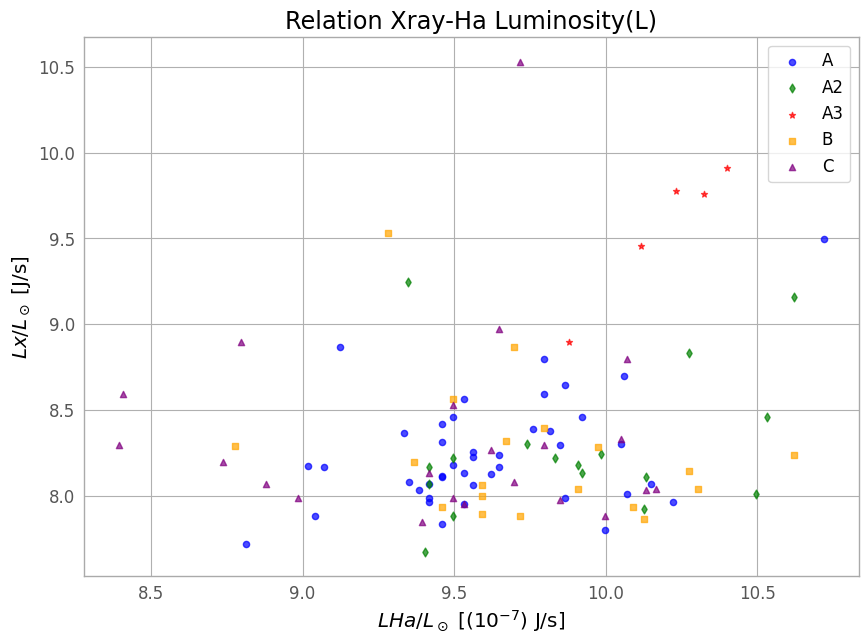

In [17]:
s = 20
colors = ['blue','green','red','orange','purple','black','cyan', 'brown', 'yellow', 'grey']


# We will normalice to solar lum to have smaller values
Ls = 3.828e26*u.W # Solar Luminosity
# Setting the parameters and data
marks = Markers(6,1)
l10 = np.linspace(np.min(np.log10(M['Lx'])), np.max(np.log10(M['LHa (10-7W)'])), 1000)
l   = np.linspace(-3, np.max(M['LHa (10-7W)']/Ls), 1000)

topx = [None ,3e10]
topy = [None, 1e10]
# Making the plot
fig, ax1= plt.subplots( figsize= (10,7))
axs = [ax1]
for i,ax in enumerate(axs):
    for c,df in enumerate(Dm[:-1]):
        ax.scatter(np.log10(df['LHa (10-7W)']/Ls),np.log10(df['Lx']/Ls),s=s,  alpha=0.7, 
                   label=morfs[c], marker=marks[c], c= colors[c])
        
    #ax.plot(l,l,':', color='black', alpha=1)
    #ax.plot([3e10 for i in l],l,'-', color='brown', alpha=1) #vert
    #ax.plot(l,[1e10 for i in l],'-', color='brown', alpha=1)
    ax.set_title('Relation Xray-Ha Luminosity(L)', loc='center')
    ax.set_xlabel('$LHa/L_\odot$ [$(10^{-7})$ J/s]')
    ax.set_ylabel('$Lx/L_\odot$ [J/s]')
    #ax.set_ylim(-3,topy[i])
    #ax.set_xlim(-3,topx[i])
    ax.legend()
#plt.savefig('../Images/Long_LHa-Xray.png')

We see there are some dispersed SNRs and one that peaks in Xray (025) so we take them out and try to have clearer data

In [18]:
# Quitamos
cond = M['N'] == 'L10-025'
M1 =  M.drop(index=14).copy()
cond1 = M1['N'] =='L10-045'
M2 =  M1.drop(index=28).copy()
cond2 = M1['N'] =='L10-037'
M3 =  M2.drop(index=22).copy()

In [19]:
M3['Halum'] = F2L(M3['Haflux'])
M3

,N,Field,Morf,R,R(pc)_x,R-err(pc),Cent,Haflux,Haflux-err,SII6717flux,...,SII/Ha,SIIflux-err,SII/Ha-err,S/N-Haflux,S/N-SIIflux,Diam (pc),R(pc)_y,LHa (10-7W),Lx,Halum
0,L10-002,F7,C,14,17.636358,1.25974,14,2.361649e-14,2.377403e-17,7.791893e-15,...,0.559296,2.322249e-17,0.000563,993.373557,993.373557,29,14.5,1.600000e+36,7.100000e+34,1.863109e+32
1,L10-005,F7,B,18,22.675318,1.25974,18,1.576058e-14,2.458956e-17,6.860337e-15,...,0.761283,2.803008e-17,0.001188,640.945913,640.945913,45,22.5,1.200000e+36,1.400000e+35,1.243355e+32
2,L10-006,F7,B,25,31.493497,1.25974,25,4.057449e-14,3.086936e-17,1.289983e-14,...,0.551139,3.260301e-17,0.000419,1314.393732,1314.393732,56,28.0,2.400000e+36,9.500000e+34,3.200929e+32
3,L10-008,F7,A,22,27.714277,1.25974,22,7.064017e-14,4.094556e-17,2.301121e-14,...,0.555002,3.838940e-17,0.000322,1725.221606,1725.221606,51,25.5,4.500000e+36,3.900000e+34,5.572817e+32
4,L10-011,F7,A3,10,12.597399,1.25974,10,3.682748e-14,3.544525e-17,1.544505e-14,...,0.786328,3.603340e-17,0.000757,1038.996332,1038.996332,20,10.0,2.900000e+36,3.000000e+35,2.905327e+32
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100,L10-126,SE,A,28,35.272716,1.25974,24,2.163567e-14,2.363220e-17,9.839486e-15,...,0.805496,2.796904e-17,0.000880,915.516502,915.516502,46,23.0,1.100000e+36,2.600000e+34,1.706842e+32
101,L10-127,SE,A,40,50.389595,1.25974,35,9.280543e-14,2.772385e-17,2.391908e-14,...,0.445903,3.171786e-17,0.000133,3347.494564,3347.494564,86,43.0,4.300000e+36,7.700000e+34,7.321438e+32
102,L10-128,NE,A2,15,18.896098,1.25974,15,5.214329e-14,2.530310e-17,2.413836e-14,...,0.782499,2.639895e-17,0.000380,2060.746975,2060.746975,22,11.0,2.600000e+36,6.300000e+34,4.113594e+32
103,L10-129,NE,A2,22,27.714277,1.25974,13,9.549184e-14,3.489014e-17,5.370148e-14,...,0.963795,3.687896e-17,0.000352,2736.929149,2736.929149,39,19.5,7.200000e+36,2.600000e+35,7.533369e+32


In [20]:
# Función para el ajuste
def func(x, a, b):
    return a*x+b

[3.17070537e+01 1.72100712e+08]
[-5.33574868e+01  4.40365438e+08]
[ 6.08371258e+03 -3.89147729e+09]


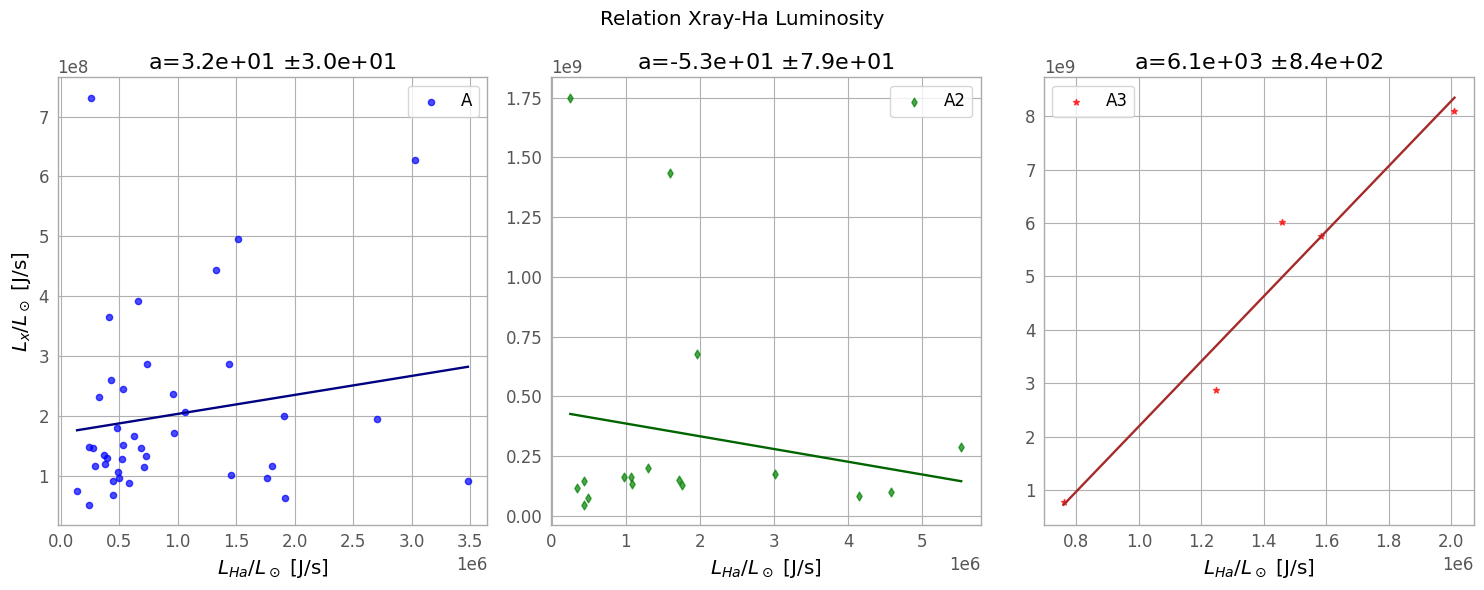

In [59]:
Dm, morf = MorfSeparator(M3)
# Vamos a hacer cada clase por separado
# Normalizamos a lum solar
Ls = 3.828e26*u.W # Solar Luminosity

clr = ['navy', 'darkgreen', 'brown']

# Making the plot
fig, ax= plt.subplots(1,3, figsize=(15,6), layout='tight')
fig.suptitle('Relation Xray-Ha Luminosity')

A   = [[] for i in Dm[:3]]
cov = [[] for i in Dm[:3]]
xlab = ['$L_x/L_\odot$ [J/s]',None,None]
for c,df in enumerate(Dm[:3]):
    H = df['Halum']/Ls
    X = df['Lx']/Ls
    
    # Hacemos un ajuste para cada clase
    A[c], cov[c] = curve_fit(func,H,X)
    print(A[c])
    # Plot del ajuste
    l = np.linspace(np.min(H), np.max(H), 1000)
    ax[c].plot(l,A[c][0]*l+A[c][1], c=clr[c])
    #Scatter
    ax[c].scatter(H,X,s=s,  alpha=0.7, 
               label=morfs[c], marker=marks[c], c= colors[c])
    ax[c].set_title(f'a={A[c][0]:.1e} $\pm${np.sqrt(cov[c][0][0]):.1e}', fontsize=16)
    ax[c].set_xlabel('$L_{Ha}/L_\odot$ [J/s]')
    ax[c].set_ylabel(xlab[c])
    #ax[c].set_ylim(0,0.5e36)
    ax[c].legend()
plt.savefig('../../Imágenes/My_LHa-Xray1.png')

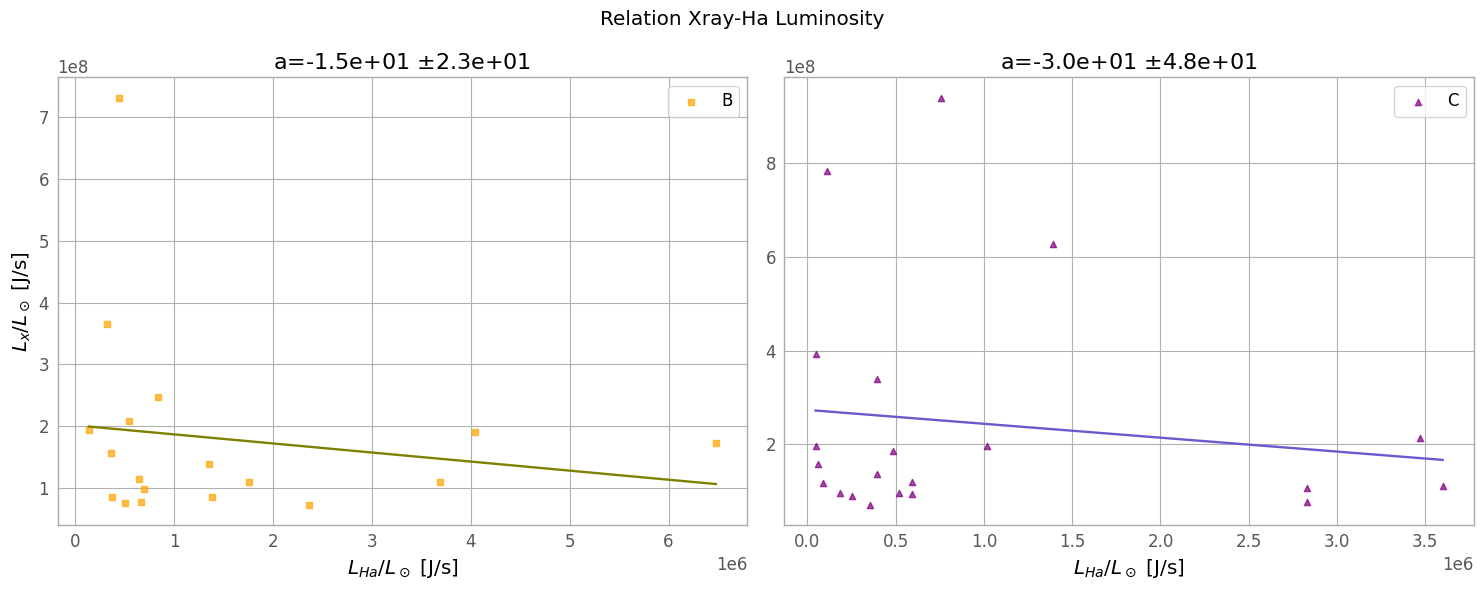

In [60]:
Dm, morf = MorfSeparator(M3)
# Vamos a hacer cada clase por separado
# Normalizamos a lum solar
Ls = 3.828e26*u.W # Solar Luminosity

clr = ['olive', 'slateblue']

# Making the plot
fig, ax= plt.subplots(1,2, figsize=(15,6), layout='tight')
fig.suptitle('Relation Xray-Ha Luminosity')

A = [[] for i in Dm[3:-1]]
cov = [[] for i in Dm[3:-1]]
xlab = ['$L_x/L_\odot$ [J/s]',None,None]
for c,df in enumerate(Dm[3:-1]):
    H = df['Halum']/Ls
    X = df['Lx']/Ls
    
    # Hacemos un ajuste para cada clase
    A[c], cov[c] = curve_fit(func,H,X)
    # Plot del ajuste
    l = np.linspace(np.min(H), np.max(H), 1000)
    ax[c].plot(l,A[c][0]*l+A[c][1], c=clr[c])
    #Scatter
    ax[c].scatter(H,X,s=s,  alpha=0.7, 
               label=morfs[c+3], marker=marks[c+3], c= colors[c+3])
    ax[c].set_title(f'a={A[c][0]:.1e} $\pm${np.sqrt(cov[c][0][0]):.1e}', fontsize=16)
    ax[c].set_xlabel('$L_{Ha}/L_\odot$ [J/s]')
    ax[c].set_ylabel(xlab[c])
    #ax[c].set_ylim(0,0.5e36)
    ax[c].legend()
plt.savefig('../../Imágenes/My_LHa-Xray2.png')

Ahora sí está biene escalado LHa

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Text(0, 0.5, 'LXray [J/s]')

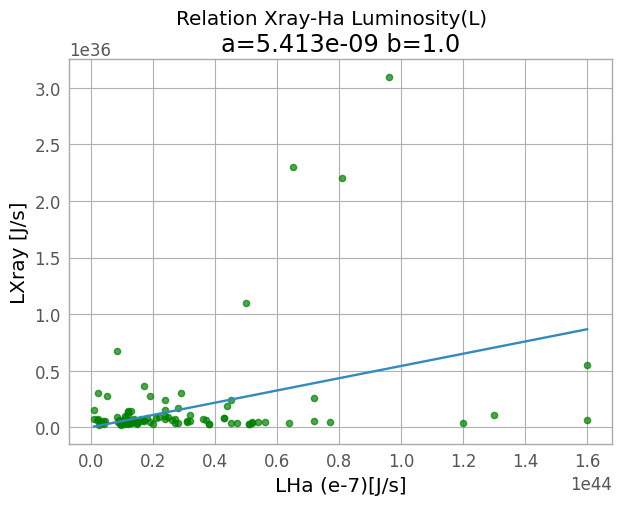

In [24]:
df = M3.copy()
#Ajuste para todas juntas
fig, ax= plt.subplots( figsize=(7,5))
fig.suptitle('Relation Xray-Ha Luminosity(L)')

# Hacemos un ajuste para cada clase
A, cov = curve_fit(func,df['LHa (10-7W)']*1e7,df['Lx'])
# Plot del ajuste
l = np.linspace(np.min(df['LHa (10-7W)']*1e7), np.max(df['LHa (10-7W)']*1e7), 1000)
ax.plot(l,A[0]*l+A[1])
#Scatter
ax.scatter(df['LHa (10-7W)']*1e7,df['Lx'],s=s,  alpha=0.7, c= colors[c])
ax.set_title(f'a={A[0]:.3e} b={A[1]}')
ax.set_xlabel('LHa (e-7)[J/s]')
ax.set_ylabel('LXray [J/s]')
#ax.set_ylim(0,1e36)
#ax.set_xlim(0,0.8e44)

Se podría quitar las remanentes con Lx>1e36 y LHa>0.8e44

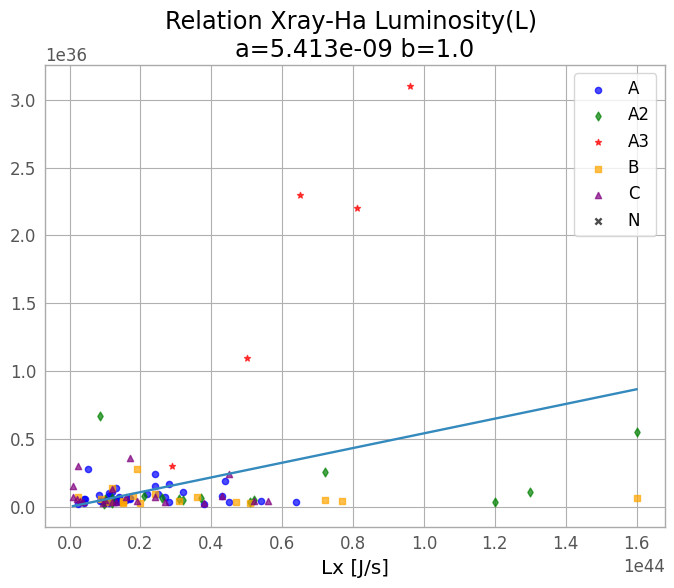

In [25]:
s = 20
colors = ['blue','green','red','orange','purple','black','cyan', 'brown', 'yellow', 'grey']

# Setting the parameters and data
marks = Markers(6,1)
l10 = np.linspace(np.min(np.log10(M['Lx'])), np.max(np.log10(M['LHa (10-7W)'])), 1000)
l   = np.linspace(np.min(M3['LHa (10-7W)']*1e7), np.max(M3['LHa (10-7W)']*1e7), 1000)

Dm, morf = MorfSeparator(M3)

# Making the plot
fig, ax= plt.subplots()

for c,df in enumerate(Dm):
    ax.scatter(df['LHa (10-7W)']*1e7,df['Lx'],s=s,  alpha=0.7, 
               label=morfs[c], marker=marks[c], c= colors[c])

ax.plot(l,A[0]*l+A[1])
    
#ax.plot(l,l,':', color='black', alpha=1)
ax.set_title(f'Relation Xray-Ha Luminosity(L) \na={A[0]:.3e} b={A[1]}', loc='center')
ax.set_xlabel('LHa [J/s]')
ax.set_xlabel('Lx [J/s]')
#ax.set_ylim(0,0.2e36)
#ax.set_xlim(0,1e37)
ax.legend()
#plt.savefig('../Images/Long_LHa-Xray.png')

# GridSpec plot

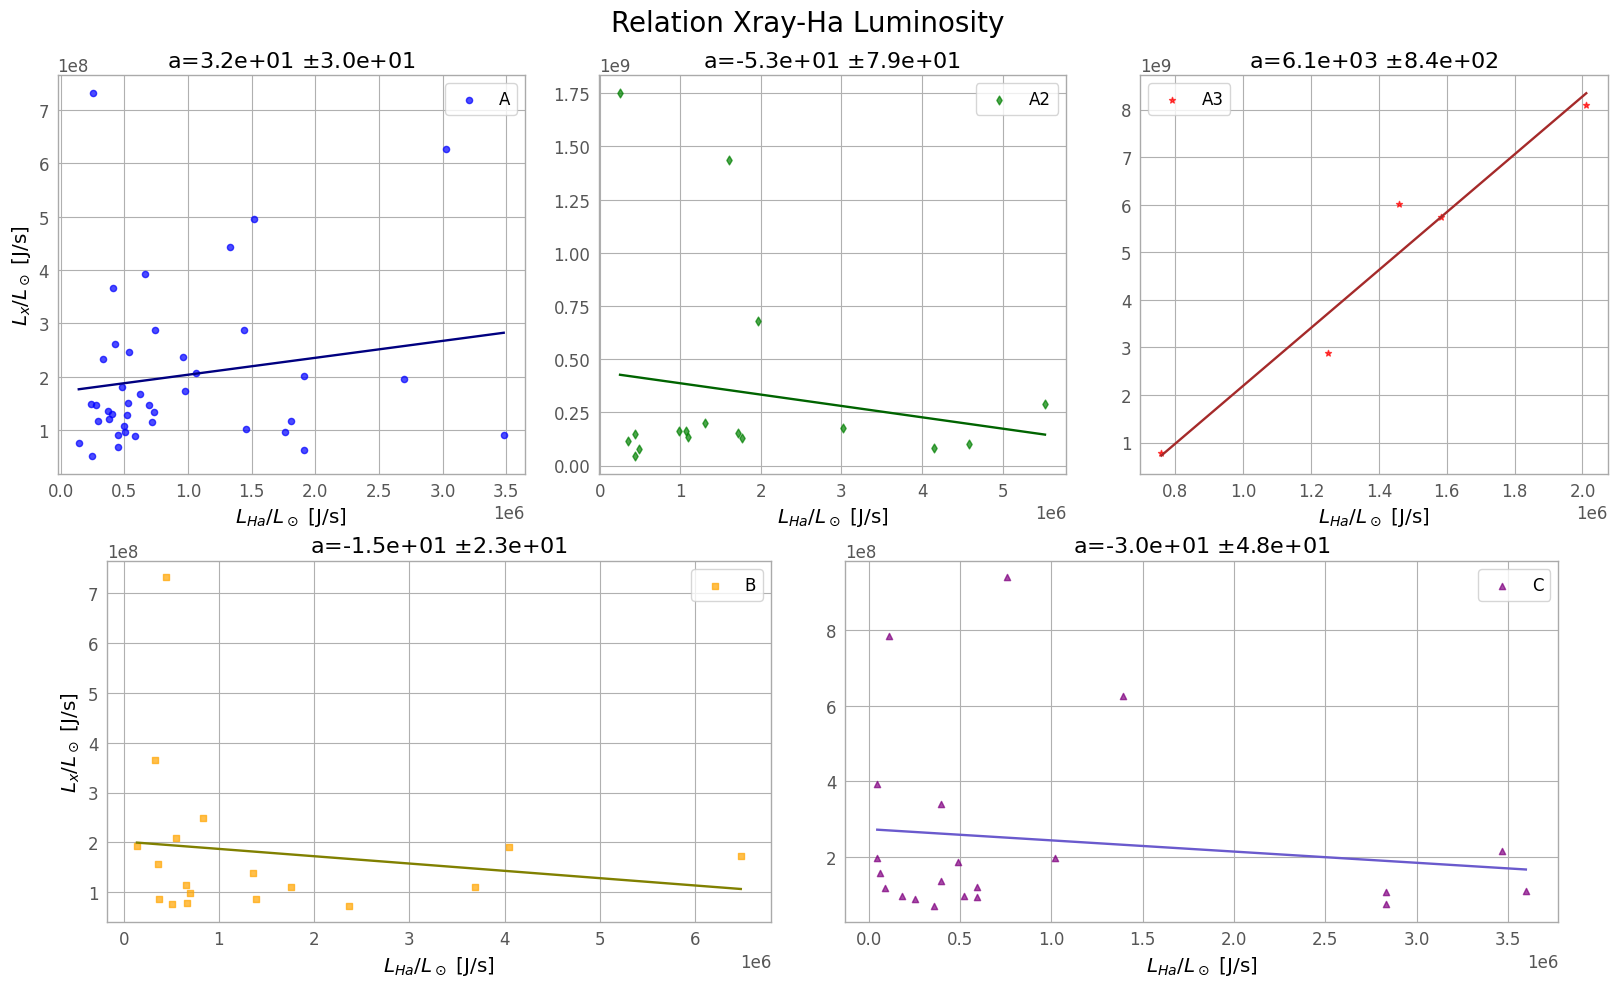

In [86]:
fig = plt.figure( figsize=(20,11)) #,layout="tight")

gs = gridspec.GridSpec(23,32, wspace=1) # Building the plane
# Building the grid
#ax1 = [plt.subplot(gs[0:10, 0+10*i:10+10*i])for i in range(3)]  # Top
ax1 = [plt.subplot(gs[0:11, 0:10]),plt.subplot(gs[0:11, 11:21]),plt.subplot(gs[0:11, 22:])]  # Top
ax2 = [plt.subplot(gs[13:,1:15]), plt.subplot(gs[13:,16:31])]# Bottom
ax = ax1+ax2

fig.suptitle('Relation Xray-Ha Luminosity', y=0.94,size=20)

clr = ['navy', 'darkgreen', 'brown', 'olive', 'slateblue']
A   = [[] for i in Dm[:-1]]
cov = [[] for i in Dm[:-1]]
xlab = ['$L_x/L_\odot$ [J/s]',None,None,'$L_x/L_\odot$ [J/s]',None]
for c,df in enumerate(Dm[:-1]):
    H = df['Halum']/Ls
    X = df['Lx']/Ls
    
    # Hacemos un ajuste para cada clase
    A[c], cov[c] = curve_fit(func,H,X)
    # Plot del ajuste
    l = np.linspace(np.min(H), np.max(H), 1000)
    ax[c].plot(l,A[c][0]*l+A[c][1], c=clr[c])
    #Scatter
    ax[c].scatter(H,X,s=s,  alpha=0.7, 
               label=morfs[c], marker=marks[c], c= colors[c])
    ax[c].set_title(f'a={A[c][0]:.1e} $\pm${np.sqrt(cov[c][0][0]):.1e}', fontsize=16)
    ax[c].set_xlabel('$L_{Ha}/L_\odot$ [J/s]')
    ax[c].set_ylabel(xlab[c])
    #ax[c].set_ylim(0,0.5e36)
    ax[c].legend()
plt.savefig('../../Imágenes/My_LHa-Xrayspec.png')